# **Open-source GIS Land Suitability Analysis**

## **Introduction**
This project will focus on creating an open-source GIS Land Suitability Analysis as part of a larger Regional Catastrophic Grant Program (RCGP) by FEMA. Disaster Housing has been chosen as the capability gap to focus on. As part of this process, tools will be built for others to utilize when creating their own disaster housing plan. This includes an open-source GIS land suitability analysis inspired by work completed by the Hurricane Matthew Disaster Recovery and Resilience Initiative.

## **Databases**

1.   MBHSR_UASI
2.   NFHL
3.   MA_LCLU2016





## **Land Suitability Analysis Process and Methods**

### **LSA Variable Identification, Weighting, and Procedures**
**1.   GIS and MS Excel Suitability Scoring Procedures**

> The LSA was done using QGIS 3.18.3 and Jupyter Notebook + Python. The layers used for the LSA were already vectorized so no processing in that regard was required. The next step was to apply the 50/50 rule. This was done primarily using the Intersection tool found under the Vector overlay section of the Analysis Tools in the QGIS Toolbox. 
Intersection generate an "intersection" temporary layer which  features are the result of a join of an input layer and an overlay layer. To calculate the overlapping area and its percentage of total area between two vector-based data layers we used the field calculator inside intersection layer's attribute table (see Apendix Section A). 



## **Data Transformation**
The NFHL database is stored in GeoDataBase format. In QGIS you can only edit layers, when they are stored in the data formats shapefile, SpatialLite, PostGIS or other databanks.
We are going to convert files from GeoDataBase (.gdb) to GeoPackage (.gpkg). 

You should open OSGeo4W shell and execute the following command:


```
ogr2ogr -f "GPKG" <output_path>\<output_geopackage_name>.gpkg <input_path>\<input_geodatabase_name>
```

Its recommended to manage this type of files in GeoPackage, so we recommend to convert all the databases to this format.

---------------------------------------------------
We also need to have a csv file with the Boston Zoning Layer attributes as we will need it.
To do so, just run the following command:
```
ogr2ogr -f "CSV" <output_path>\<output_geopackage_name>.csv <input_path>\<input_geopackage_name>
```

## Requirements

### **PyQGIS & Jupyter Notebook**
We are using Jupyter Notebook to do the analysis. Its important to be sure that this integration is installed in your computer. Yo can check this tutorial to do so: https://lerryws.xyz/posts/Install-Jupyter-Notebook-in-QGIS3

Aditionally, we'll be using PyQGIS library. In order to be able to use it you should have it installed as well.
If not, there is a tutorial that may be helpful: https://lerryws.xyz/posts/Install-Jupyter-Notebook-in-QGIS3

### Jupyter notebook location
In the first instance, we need the jupyter notebook to be located in the bin folder of the OSGeo4W64 installation. This will help us to access QGIS core functionalities easily.

The folder structure shoul be as follows:
```
OSGeo4W64
│   ...
|
│
└───bin
    │
    |   run-jupyter.bat
    |   ...
    │
    └───land_suitability_analysis_folder
        │   GIS_land_suitability_analysis_local.ipynb (notebook)
        │   ...

```

## Opening Jupyter Notebook 

If you followed the tutorial to use PyQGIS in a Jupyter Notebook you should have a file named `run-jupyter.bat` in your bin folder of OSGeo4W64 installation. 

Open a terminal, then go to the bin folder and execute run-jupyter.bat file. A new tab in your default browser will open 

## Imports
We need to import all the libraries we are going to use.

In [1]:
import os
from os.path import expanduser

# QGIS core functionality imports
from qgis import *
from qgis.core import *
from qgis.core import QgsApplication
from qgis.core import QgsExpression
from qgis.core import QgsVectorDataProvider
from qgis.core import QgsVectorLayer
from qgis.PyQt.QtCore import QVariant
from qgis.utils import iface
from PyQt5 import QtCore
from PyQt5 import QtGui
from PyQt5 import QtWidgets
from PyQt5.QtCore import QFileInfo
# QGIS Image tools
from PyQt5.QtGui import QImage
from PyQt5.QtCore import QSize
from PyQt5.QtGui import QColor
from PyQt5.QtGui import QPainter
from qgis.core import QgsRectangle
# QGIS Processing tools imports
sys.path.append('C:/OSGeo4W64/apps/qgis/python/plugins')
from processing.core.Processing import Processing
Processing.initialize()
from processing.tools import *
# Data manipulation imports
import pandas as pd
# Plot images imports
from IPython import display

## **Data folders paths** 

Since you'll be working with layers that are stored somewhere in your computer, you need to store the path of the folder where these layers are located into a variable. So, the script will be able to know where to search to find the layers and work with them. 
* **DATA_PATH**: This variable will contain the general path where the folder with the layers is contained and also where you want to store the output files that are going to be generated during the analysis. You should change this accordingly to where your data is located.
* **INPUT_LAYERS_PATH**: This variable contains the *DATA_PATH* direction and we are adding the specific name of the folder where your layers are stored. You may change the folder name(input_layers) to the name of your folder if it's different.
* **OUTPUT_FILES_PATH**: This variable contains the *DATA_PATH* direction and we are adding the name of the folder where the generated csv files will be stored, you don't need to have this folder created, since it will be created automatically by the script. You can change the default folder name (output_file) if you want.
* **OUTPUT_LAYERS_PATH**: This variable contains the *DATA_PATH* direction and we are adding the name of the folder where the generated layers will be stored, you don't need to have this folder created, since it will be created automatically by the script. You can change the default folder name (output_layers) if you want.

``As you can see, you can write the whole path directly to the variables. But, we decided to have the variable DATA_PATH in case this path changes, you'll need only to change this variable and not all of them.``

In [2]:
# Change these paths accordingly to where your data folders are located
DATA_PATH = "C:/Users/59399/OneDrive/Documents/GSOC2021/"
# Change this path with the name of the folder where your input layers are located
INPUT_LAYERS_PATH = DATA_PATH + "input_layers/"
# Change this path with the name of the folder where you'll save the output files (It'll be created automatically)
OUTPUT_FILES_PATH = DATA_PATH + "output_files/"
# Change this path with the name of the folder where you'll save the output layers (It'll be created automatically)
OUTPUT_LAYERS_PATH = DATA_PATH + "output_layers/"

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


As said in the previous section, you don't need to have the output_files and output_layer folders created on your computer. To do that automatically, the function **create_directory_if_do_not_exist** verify if these folders are already created in your machine, if not, it creates them for you.

In [3]:
# This function will create a folder if it doesn't exist
def create_directory_if_do_not_exist(dirName):
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print(f"Directory {dirName} created ")
    else:    
        print(f"Directory {dirName} \033[1m already exists \033[0m")

In [4]:
create_directory_if_do_not_exist(OUTPUT_LAYERS_PATH)
create_directory_if_do_not_exist(OUTPUT_FILES_PATH)

Directory C:/Users/59399/OneDrive/Documents/GSOC2021/output_layers/  already exists 
Directory C:/Users/59399/OneDrive/Documents/GSOC2021/output_files/  already exists 


## Project Instance
We are working in a standalone PyQGIS script, so we need to instantiate the layers from our QGIS project.

In [5]:
'''
home = expanduser("~")
QgsApplication( [], False, home + "/AppData/Local/Temp" )
QgsApplication.setPrefixPath("C:/OSGeo4W64/apps/qgis", True)
app = QtWidgets.QApplication([])

QgsApplication.initQgis()

fname = r"C:/Users/59399/OneDrive/Documents/GSOC2021/Land Suitability Analysis.qgz"

# Get the project instance
project = QgsProject.instance()
# Open the project
project.read(fname)
print(project.fileName())
'''

C:/Users/59399/OneDrive/Documents/GSOC2021/Land Suitability Analysis.qgz
{'9inch_sea_level_rise_10pct_2dd2e293_990d_4665_9b4a_d8911b37c5a5': <QgsVectorLayer: '9inch sea level rise 10pct' (ogr)>, 'BPDA_ZONING_80ead0ce_6798_4eb5_ba55_1b77b05d0a95': <QgsVectorLayer: 'BPDA_ZONING' (ogr)>, 'fixed_BPDA_ZONING_68e87b4c_8d55_4cf0_ba3b_564658383c10': <QgsVectorLayer: 'fixed_BPDA_ZONING' (ogr)>, 'fixed_S_FLD_HAZ_AR_a6099c4a_c816_4875_bf76_78317ba292a7': <QgsVectorLayer: 'fixed_S_FLD_HAZ_AR' (ogr)>}


For the analysis, you'll be working with some layers that are stored in your computer. To be able to work with them we need to load them using **QgsVectorLayer** functionality. The problem with this pyQGIS' function is that if you mistype the layer name it won't throw an error message, instead, it creates an empty layer.
To prevent this to happen and to give more feedback to users on what is going on, the function we have created a wrapper function called **load_layer**. This function calls QgsVectorLayer function and throws an error if the layer that has been created is empty.

In [94]:
def load_layer(layer_path, provider="ogr"):
    layer = QgsVectorLayer(layer_path, provider)
    if layer.featureCount() < 0:
        raise ValueError(f"The layer is empty, you may check layer path: {layer_path}")
    else:
        print(f"Layer {layer_path} \033[1m loaded succesfully \033[0m")

You have to verify the name of the layers and change them if you have named them in a different manner. If any of your layers paths are not found, you'll see an error message.

In [95]:
# Storing layers into variables
sea_level_rise_layer = load_layer(f"{INPUT_LAYERS_PATH}9inch_eSea_Level_Rise_10pct_Annual_Flood.gpkg", "ogr")
boston_zoning_layer =  load_layer(f"{INPUT_LAYERS_PATH}fixed_BPDA_ZONING.gpkg", "ogr")
flz_haz_layer = load_layer(f"{INPUT_LAYERS_PATH}fixed_S_FLD_HAZ_AR.gpkg", "ogr")

Layer C:/Users/59399/OneDrive/Documents/GSOC2021/input_layers/9inch_eSea_Level_Rise_10pct_Annual_Flood.gpkg  loaded succesfully 
Layer C:/Users/59399/OneDrive/Documents/GSOC2021/input_layers/fixed_BPDA_ZONING.gpkg  loaded succesfully 
Layer C:/Users/59399/OneDrive/Documents/GSOC2021/input_layers/fixed_S_FLD_HAZ_AR.gpkg  loaded succesfully 


## Area calculation

Function **calculate_layer_area** receives two inputs:
1. **layer**: layer to add area calculation field
2. **output_field_name**: name of the new column that is going to be created in the layer features table.
What the function does is that it'll create a new column with the specified output name. Then, it will calculate the area of each parcel in the layer and add the values in this new created column.

In [8]:
# Define an expression for AREA calculation
area_expression = QgsExpression("$area")

def calculate_layer_area(layer, output_field_name):
    # We need to pass the path where the data is located, a layer name and a provider 
    # In this case org is the correct provider for geopackages.

    provider = layer.dataProvider()
    provider.addAttributes([QgsField(output_field_name, QVariant.Double)])

    # Need to give context where it occurs
    context = QgsExpressionContext()
    context.appendScopes(QgsExpressionContextUtils.globalProjectLayerScopes(layer))

    with edit(layer):
        for f in layer.getFeatures():
            context.setFeature(f)
            f[output_field_name] = area_expression.evaluate(context)
            layer.updateFeature(f)
      

    
# BOSTON ZONING layer - area calculation
calculate_layer_area(boston_zoning_layer, "boston_polyg_area")

# FLZ_HAZ layer - area calculation
calculate_layer_area(flz_haz_layer, "flz_b_polyg_area")

# Sea level rise layer - area calculation
calculate_layer_area(sea_level_rise_layer, "searise_polyg_area")

## **Intersect Layers** 

To intersect to layers you'll need to run **Processing.runAlgoritm** function, it receives two parameters:
1. **Algorithm ID**: QGIS has different vector overlay functionalities, since we want to perform intersections between two layers you'll need to pass "qgis:intersection" id. For reference, you can check this link: https://docs.qgis.org/3.16/en/docs/user_manual/processing_algs/qgis/vectoroverlay.html
2. **Dictionary**: Dictionary with all the parameters for performing intersection, in this case those are: input layer, overlay layer and output layer name. You can change output layers name or keep the names that are written below, as you prefer.

In [12]:
#Intersect Flood Hazard layer with Boston Zoning layer
parameters_boston_flz = {
       'INPUT': boston_zoning_layer,
       'OVERLAY': flz_haz_layer,
       'OUTPUT': OUTPUT_LAYERS_PATH + 'intersection_flz_boston.gpkg'
}
Processing.runAlgorithm("qgis:intersection", parameters_boston_flz)

#Intersect Sea Rise layer with Boston Zoning layer
parameters_boston_searise = {
       'INPUT': boston_zoning_layer,
       'OVERLAY': sea_level_rise_layer,
       'OUTPUT': OUTPUT_LAYERS_PATH + 'intersection_searise_boston.gpkg'
}
Processing.runAlgorithm("qgis:intersection", parameters_boston_searise)

{'OUTPUT': 'C:/Users/59399/OneDrive/Documents/GSOC2021/output_layers/intersection_flz_boston.gpkg'}

## Export layers as CSV files

After intersecting the layer, we'll need to use them for the analysis. To do so, we are loading the layers into variables.

In [96]:
# Intersected layers to export
intersection_flz_boston_layer = load_layer(f"{OUTPUT_LAYERS_PATH}intersection_flz_boston.gpkg", "ogr")
intersection_searise_boston_layer = load_layer(f"{OUTPUT_LAYERS_PATH}intersection_searise_boston.gpkg", "ogr")

Layer C:/Users/59399/OneDrive/Documents/GSOC2021/output_layers/intersection_flz_boston.gpkg  loaded succesfully 
Layer C:/Users/59399/OneDrive/Documents/GSOC2021/output_layers/intersection_searise_boston.gpkg  loaded succesfully 


Since we are going to perform some data manipulation to the layers features tables, it'll be easier to work with python and loading the data into dataframes. That's why the next step will be to save the layers features into csv files.

The function **QgsVectorFileWriter.writeAsVectorFormat** will do that work for you, and it needs the following inputs:
1. **layer**: layer to write.
2. **csv file name**: file name to write to. File name can be changed.
3. **encoding**: encoding to use.
4. **driverName**: OGR driver to use.
5. **layerOptions**: list of OGR layer creation options.

In [67]:
# Export boston zoning layer as csv file
QgsVectorFileWriter.writeAsVectorFormat(
    boston_zoning_layer, 
    f"{OUTPUT_FILES_PATH}boston_zoning.csv", 
    "utf-8", 
    driverName = "CSV", 
    layerOptions = ['GEOMETRY=AS_XYZ']
)

# Export intersect layer between boston zoning layer and flood hazard layer as csv file
QgsVectorFileWriter.writeAsVectorFormat(
    intersection_flz_boston_layer, 
    f"{OUTPUT_FILES_PATH}intersection_flz_boston.csv", 
    "utf-8", 
    driverName = "CSV", 
    layerOptions = ['GEOMETRY=AS_XYZ']
)

# Export intersect layer between boston zoning layer and sea level rise layer as csv file
QgsVectorFileWriter.writeAsVectorFormat(
    intersection_searise_boston_layer, 
    f"{OUTPUT_FILES_PATH}intersection_searise_boston.csv", 
    "utf-8", 
    driverName = "CSV", 
    layerOptions = ['GEOMETRY=AS_XYZ']
)

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: QgsVectorFileWriter.writeAsVectorFormat() is deprecated
  import sys
C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: QgsVectorFileWriter.writeAsVectorFormat() is deprecated
  app.launch_new_instance()
C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: QgsVectorFileWriter.writeAsVectorFormat() is deprecated


(0, '')

## **Data Manipulation**

> ### Load Boston Zoning file as dataframe

We are loading the boston zoning layer features into a dataframe. As we can see there are 1649 parcels and 14 fields related to each one. 
You may check if the name of the csv file match the one that you have in your machine.

In [68]:
boston_zoning = pd.read_csv(OUTPUT_FILES_PATH + "boston_zoning.csv")
boston_zoning

,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,Community Commercial,1.271921e+05,1510.634543,1.181654e+04
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,3.831879e+05
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,4.322127e+04
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,Neighborhood Development Area,6.826984e+05,5332.158658,6.342475e+04
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,Local Industrial,5.708634e+05,3059.384700,5.303494e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,1645,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,4.472167e+05,3453.569106,4.154779e+04
1645,1646,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,2.488642e+05,3250.624195,2.312024e+04
1646,1647,OS-CM,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-CM,0.0,0,0,Cemetery Open Space,1.218112e+07,18092.656078,1.131663e+06
1647,1648,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,Botanical/Zoological Garden Open Space,1.148609e+07,19742.470508,1.067093e+06


> ### Load intersected layers files (Boston & Flood Hazard) as dataframes

Now we are loading the intersected layers attributes tables. You may check if the name of the csv file match the one that you have in your machine.

In [69]:
# Load Flood Hazard & Boston Zoning intersection file
intersection_flz_boston = pd.read_csv(OUTPUT_FILES_PATH + "intersection_flz_boston.csv")
# Load Sea Rise & Boston Zoning intersection file
intersection_searise_boston = pd.read_csv(OUTPUT_FILES_PATH + "intersection_searise_boston.csv")

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We are printing each dataframe to make sure the data has been loaded correctly.

In [70]:
intersection_flz_boston

,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,...,AR_SUBTRV,BFE_REVERT,DEP_REVERT,DUAL_ZONE,SOURCE_CIT,GFID,SHAPE_Length,SHAPE_Area,flz_polyg_area,flz_b_polyg_area
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,...,NaN,-9999,-9999,NaN,25025C_FIS1,1595d434-0c9d-4c87-a996-9ed850731c36,1.409210,9.546818e-03,1.183044e+08,NaN
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,...,NaN,-9999,-9999,NaN,25025C_STUDY1,1595d434-0c9d-4c87-a996-9ed850731c36,0.014230,4.030409e-06,4.994490e+04,NaN
2,3,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,...,NaN,-9999,-9999,NaN,25025C_STUDY1,1595d434-0c9d-4c87-a996-9ed850731c36,0.216372,3.315223e-04,4.108234e+06,NaN
3,4,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,...,NaN,-9999,-9999,NaN,25025C_STUDY1,1595d434-0c9d-4c87-a996-9ed850731c36,0.013053,4.546214e-06,5.633683e+04,NaN
4,5,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,...,NaN,-9999,-9999,NaN,25025C_STUDY1,1595d434-0c9d-4c87-a996-9ed850731c36,0.040380,2.593287e-05,3.213609e+05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2722,2723,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,...,NaN,-9999,-9999,NaN,25025C_FIS1,1595d434-0c9d-4c87-a996-9ed850731c36,0.001527,1.584000e-07,1.962885e+03,NaN
2723,2724,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,...,NaN,-9999,-9999,NaN,25025C_FIS1,1595d434-0c9d-4c87-a996-9ed850731c36,0.001493,1.329980e-07,1.648114e+03,NaN
2724,2725,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,...,NaN,-9999,-9999,NaN,25025C_FIS1,1595d434-0c9d-4c87-a996-9ed850731c36,1.409210,9.546818e-03,1.183044e+08,NaN
2725,2726,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,...,NaN,-9999,-9999,NaN,25025C_FIS1,1595d434-0c9d-4c87-a996-9ed850731c36,0.002003,2.235628e-07,2.770401e+03,NaN


In [71]:
intersection_searise_boston

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area,fid_2,Shape_Leng,Shape_Area,searise_polyg_area
0,1,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,383187.879918,1,391282.743031,7.420804e+07,6.894153e+06
1,2,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,43221.268348,1,391282.743031,7.420804e+07,6.894153e+06
2,3,WC,South Boston Neighborhood,4F,68,Business,South Boston Neighborhood WC,2.0,0,0,Waterfront Commercial,3.395702e+05,2778.818794,31547.104322,1,391282.743031,7.420804e+07,6.894153e+06
3,4,I-2,South Boston,4,Underlying Zoning,Industrial,South Boston I-2,2.0,0,0,General Industrial,3.342126e+06,9555.299808,310493.707492,1,391282.743031,7.420804e+07,6.894153e+06
4,5,First St. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood First St. LI,2.0,0,0,Local Industrial,1.006033e+06,6885.163647,93463.516964,1,391282.743031,7.420804e+07,6.894153e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,130,3F-5000,Dorchester Neighborhood,5A-5E,65,Residential,Dorchester Neighborhood 3F-5000,0.5,0,0,Three-Family Residential,5.321394e+05,5327.324761,49437.369066,1,391282.743031,7.420804e+07,6.894153e+06
130,131,1F-7000,Dorchester Neighborhood,5A-5E,65,Residential,Dorchester Neighborhood 1F-7000,0.4,0,0,One-Family Residential,1.150258e+06,7114.058627,106862.440330,1,391282.743031,7.420804e+07,6.894153e+06
131,132,OS-CM,Dorchester Neighborhood,5A-5E,65,Open Space,Dorchester Neighborhood OS-CM,0.0,0,0,Cemetery Open Space,2.877991e+06,9720.195973,267374.098136,1,391282.743031,7.420804e+07,6.894153e+06
132,133,OS-P,Dorchester Neighborhood,5A-5E,65,Open Space,Dorchester Neighborhood OS-P,0.0,0,0,Parkland Open Space,5.201825e+05,3562.821700,48326.537760,1,391282.743031,7.420804e+07,6.894153e+06


> ### Join intersected layers files with the Boston Zoning layer file

In [72]:
# Flood Hazard Layer
#To avoid duplication of columns we select only the columns that we want to preserve from the intersection
columns_to_keep_flz = ["fid","flz_polyg_area", "FLD_ZONE"]

flz_boston_joined = boston_zoning.merge(
    intersection_flz_boston[columns_to_keep_flz], 
    how="left", 
    on="fid", 
    left_index=True
).reset_index(drop=True)


# Sea Level Rise Layer
#To avoid duplication of columns we select only the columns that we want to preserve from the intersection
columns_to_keep_searise = ["fid","searise_polyg_area"]

searise_boston_joined = boston_zoning.merge(
    intersection_searise_boston[columns_to_keep_searise], 
    how="left", 
    on="fid", 
    left_index=True
).reset_index(drop=True)

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
flz_boston_joined

,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area,flz_polyg_area,FLD_ZONE
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,Community Commercial,1.271921e+05,1510.634543,1.181654e+04,1.183044e+08,X
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,3.831879e+05,4.994490e+04,AE
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,4.322127e+04,4.108234e+06,X
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,Neighborhood Development Area,6.826984e+05,5332.158658,6.342475e+04,5.633683e+04,X
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,Local Industrial,5.708634e+05,3059.384700,5.303494e+04,3.213609e+05,AE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,1645,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,4.472167e+05,3453.569106,4.154779e+04,1.183044e+08,X
1645,1646,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,2.488642e+05,3250.624195,2.312024e+04,1.183044e+08,X
1646,1647,OS-CM,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-CM,0.0,0,0,Cemetery Open Space,1.218112e+07,18092.656078,1.131663e+06,2.356918e+07,X
1647,1648,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,Botanical/Zoological Garden Open Space,1.148609e+07,19742.470508,1.067093e+06,1.183044e+08,X


In [74]:
searise_boston_joined

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area,searise_polyg_area
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,Community Commercial,1.271921e+05,1510.634543,1.181654e+04,6.894153e+06
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,3.831879e+05,6.894153e+06
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,4.322127e+04,6.894153e+06
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,Neighborhood Development Area,6.826984e+05,5332.158658,6.342475e+04,6.894153e+06
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,Local Industrial,5.708634e+05,3059.384700,5.303494e+04,6.894153e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,1645,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,4.472167e+05,3453.569106,4.154779e+04,NaN
1645,1646,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,2.488642e+05,3250.624195,2.312024e+04,NaN
1646,1647,OS-CM,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-CM,0.0,0,0,Cemetery Open Space,1.218112e+07,18092.656078,1.131663e+06,NaN
1647,1648,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,Botanical/Zoological Garden Open Space,1.148609e+07,19742.470508,1.067093e+06,NaN


> ### Manage NaN values in searise_boston_joined dataframe

As you can see in the previous dataframe, the column searise_polyg_area has some NaN values. NaN values in this context are the parcels of the boston zoning layer that didn't intersect with sea rise level layer. So, we are going to replace this values with cero.

In [75]:
searise_boston_joined["searise_polyg_area"] = searise_boston_joined["searise_polyg_area"].apply(lambda x: 0 if pd.isna(x) else x)

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 If you print the searise_boston_joined dataframe you'll see that there are no NaN values anymore.

In [76]:
searise_boston_joined

,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area,searise_polyg_area
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,Community Commercial,1.271921e+05,1510.634543,1.181654e+04,6.894153e+06
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,3.831879e+05,6.894153e+06
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,4.322127e+04,6.894153e+06
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,Neighborhood Development Area,6.826984e+05,5332.158658,6.342475e+04,6.894153e+06
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,Local Industrial,5.708634e+05,3059.384700,5.303494e+04,6.894153e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,1645,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,4.472167e+05,3453.569106,4.154779e+04,0.000000e+00
1645,1646,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,2.488642e+05,3250.624195,2.312024e+04,0.000000e+00
1646,1647,OS-CM,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-CM,0.0,0,0,Cemetery Open Space,1.218112e+07,18092.656078,1.131663e+06,0.000000e+00
1647,1648,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,Botanical/Zoological Garden Open Space,1.148609e+07,19742.470508,1.067093e+06,0.000000e+00


> ### Delete Miscellaneous parcels from analysis

In [77]:
flz_boston_joined = flz_boston_joined[flz_boston_joined["SUBDISTRIC"]!="Miscellaneous"]
flz_boston_joined.head()

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area,flz_polyg_area,FLD_ZONE
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,Community Commercial,1.271921e+05,1510.634543,11816.535938,1.183044e+08,X
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,383187.879918,4.994490e+04,AE
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,43221.268348,4.108234e+06,X
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,Neighborhood Development Area,6.826984e+05,5332.158658,63424.753034,5.633683e+04,X
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,Local Industrial,5.708634e+05,3059.384700,53034.943461,3.213609e+05,AE


> ### Map flood zone hazard areas from letters to 100-year and 500-year string

Flood hazard areas identified on the Flood Insurance Rate Map are identified as a Special Flood Hazard Area (SFHA). SFHAs are labeled as Zone A, Zone AO, Zone AH, Zones A1-A30, Zone AE, Zone A99, Zone AR, Zone AR/AE, Zone AR/AO, Zone AR/A1-A30, Zone AR/A, Zone V, Zone VE, and Zones V1-V30, etc. For more information go to: https://www.fema.gov/glossary/flood-zones 

We maped each label in one of these three categories: 500-year (label B), 100-year (labels B and C) and low-risk (all the rest of the labels). Now, it easier to score each parcel since we have only three labels instead of more than ten.

In [78]:
# Mapping parcel categories their respective type of flooding risk
def map_flz_zone(zone_name):
    if zone_name == "B":
        return "500-year"
    elif zone_name == "C" or zone_name == "X":
        return "low-risk"
    return "100-year" 


flz_boston_joined["FLD_ZONE_MAP"] = flz_boston_joined["FLD_ZONE"].apply(lambda x: map_flz_zone(x))

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


You can see the label mapping in the following dataframe.

In [79]:
flz_boston_joined

,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area,flz_polyg_area,FLD_ZONE,FLD_ZONE_MAP
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,Community Commercial,1.271921e+05,1510.634543,1.181654e+04,1.183044e+08,X,low-risk
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,3.831879e+05,4.994490e+04,AE,100-year
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,4.322127e+04,4.108234e+06,X,low-risk
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,Neighborhood Development Area,6.826984e+05,5332.158658,6.342475e+04,5.633683e+04,X,low-risk
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,Local Industrial,5.708634e+05,3059.384700,5.303494e+04,3.213609e+05,AE,100-year
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,1645,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,4.472167e+05,3453.569106,4.154779e+04,1.183044e+08,X,low-risk
1645,1646,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,2.488642e+05,3250.624195,2.312024e+04,1.183044e+08,X,low-risk
1646,1647,OS-CM,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-CM,0.0,0,0,Cemetery Open Space,1.218112e+07,18092.656078,1.131663e+06,2.356918e+07,X,low-risk
1647,1648,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,Botanical/Zoological Garden Open Space,1.148609e+07,19742.470508,1.067093e+06,1.183044e+08,X,low-risk


> ### Percentage overlap calculation

In [80]:
# Flood Zone Layer
# Division between the flood zone area and the residential parcel area
flz_boston_joined["flz_perc_overlap"] = flz_boston_joined["flz_polyg_area"]/flz_boston_joined["boston_polyg_area"]


# Sea Level Rise Layer
# Division between the sea level rise area and the residential parcel area
searise_boston_joined["searise_perc_overlap"] = searise_boston_joined["searise_polyg_area"]/searise_boston_joined["boston_polyg_area"]

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


You can see now the percentage overlap calculation results as a new column in each dataframe.

In [81]:
flz_boston_joined

,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area,flz_polyg_area,FLD_ZONE,FLD_ZONE_MAP,flz_perc_overlap
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,Community Commercial,1.271921e+05,1510.634543,1.181654e+04,1.183044e+08,X,low-risk,10011.770370
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,3.831879e+05,4.994490e+04,AE,100-year,0.130340
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,4.322127e+04,4.108234e+06,X,low-risk,95.051225
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,Neighborhood Development Area,6.826984e+05,5332.158658,6.342475e+04,5.633683e+04,X,low-risk,0.888247
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,Local Industrial,5.708634e+05,3059.384700,5.303494e+04,3.213609e+05,AE,100-year,6.059418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,1645,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,4.472167e+05,3453.569106,4.154779e+04,1.183044e+08,X,low-risk,2847.430474
1645,1646,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,2.488642e+05,3250.624195,2.312024e+04,1.183044e+08,X,low-risk,5116.921604
1646,1647,OS-CM,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-CM,0.0,0,0,Cemetery Open Space,1.218112e+07,18092.656078,1.131663e+06,2.356918e+07,X,low-risk,20.827026
1647,1648,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,Botanical/Zoological Garden Open Space,1.148609e+07,19742.470508,1.067093e+06,1.183044e+08,X,low-risk,110.866094


In [82]:
searise_boston_joined

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area,searise_polyg_area,searise_perc_overlap
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,Community Commercial,1.271921e+05,1510.634543,1.181654e+04,6.894153e+06,583.432643
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,3.831879e+05,6.894153e+06,17.991573
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,4.322127e+04,6.894153e+06,159.508341
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,Neighborhood Development Area,6.826984e+05,5332.158658,6.342475e+04,6.894153e+06,108.698142
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,Local Industrial,5.708634e+05,3059.384700,5.303494e+04,6.894153e+06,129.992649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,1645,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,4.472167e+05,3453.569106,4.154779e+04,0.000000e+00,0.000000
1645,1646,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,2.488642e+05,3250.624195,2.312024e+04,0.000000e+00,0.000000
1646,1647,OS-CM,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-CM,0.0,0,0,Cemetery Open Space,1.218112e+07,18092.656078,1.131663e+06,0.000000e+00,0.000000
1647,1648,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,Botanical/Zoological Garden Open Space,1.148609e+07,19742.470508,1.067093e+06,0.000000e+00,0.000000


> ### Score Calculation

In [83]:
#Flood zone score calculation
flz_zone_type_scoring = {
    "500-year": 1,
    "100-year": 4 
}
def get_score_flz_zone(perc_overlap, flz_zone_type):
    if perc_overlap <= 50:
        return flz_zone_type_scoring[flz_zone_type]
    return 0

#Init with flz_zone_score 0 (when perc_overlap >50)
flz_boston_joined["flz_zone_score"] = 4

condition_100_flz_zone = flz_boston_joined["FLD_ZONE_MAP"] == "100-year" 
condition_500_flz_zone = flz_boston_joined["FLD_ZONE_MAP"] == "500-year"

flz_boston_joined.loc[condition_100_flz_zone, "flz_zone_score"] = flz_boston_joined["flz_perc_overlap"].apply(
    lambda x: get_score_flz_zone(x, "100-year")
)
flz_boston_joined.loc[condition_500_flz_zone, "flz_zone_score"] = flz_boston_joined["flz_perc_overlap"].apply(
    lambda x: get_score_flz_zone(x, "500-year")
)


# Areas of future development score calculation
areas_of_future_dev_scoring = {
    "Industrial" : 0,
    "Business" : 0,
    "Comm/Instit" : 0,
    "Mixed Use" : 1,
    "Open Space" : 2,
    "Residential" : 2
}
def get_score_of_areas_of_future_dev(subdistric):
    return areas_of_future_dev_scoring[subdistric]


flz_boston_joined["future_dev_score"] = flz_boston_joined["SUBDISTRIC"].apply(
    lambda x: get_score_of_areas_of_future_dev(x)
)


#Sea level rise score calculation
def searise_score_calculation(perc_overlap):
    if perc_overlap <= 50:
        return 4
    return 0

searise_boston_joined["searise_score"] = searise_boston_joined["searise_perc_overlap"].apply(
    lambda x: searise_score_calculation(x)
)

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\59399\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

After executing the code above, you now can see the score results for each layer as a new column in their respective dataframes.

In [84]:
flz_boston_joined

,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area,flz_polyg_area,FLD_ZONE,FLD_ZONE_MAP,flz_perc_overlap,flz_zone_score,future_dev_score
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,Community Commercial,1.271921e+05,1510.634543,1.181654e+04,1.183044e+08,X,low-risk,10011.770370,4,0
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,3.831879e+05,4.994490e+04,AE,100-year,0.130340,4,0
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,4.322127e+04,4.108234e+06,X,low-risk,95.051225,4,0
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,Neighborhood Development Area,6.826984e+05,5332.158658,6.342475e+04,5.633683e+04,X,low-risk,0.888247,4,1
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,Local Industrial,5.708634e+05,3059.384700,5.303494e+04,3.213609e+05,AE,100-year,6.059418,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,1645,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,4.472167e+05,3453.569106,4.154779e+04,1.183044e+08,X,low-risk,2847.430474,4,0
1645,1646,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,2.488642e+05,3250.624195,2.312024e+04,1.183044e+08,X,low-risk,5116.921604,4,0
1646,1647,OS-CM,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-CM,0.0,0,0,Cemetery Open Space,1.218112e+07,18092.656078,1.131663e+06,2.356918e+07,X,low-risk,20.827026,4,2
1647,1648,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,Botanical/Zoological Garden Open Space,1.148609e+07,19742.470508,1.067093e+06,1.183044e+08,X,low-risk,110.866094,4,2


In [85]:
searise_boston_joined

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area,searise_polyg_area,searise_perc_overlap,searise_score
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,Community Commercial,1.271921e+05,1510.634543,1.181654e+04,6.894153e+06,583.432643,0
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,3.831879e+05,6.894153e+06,17.991573,4
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,4.322127e+04,6.894153e+06,159.508341,0
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,Neighborhood Development Area,6.826984e+05,5332.158658,6.342475e+04,6.894153e+06,108.698142,0
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,Local Industrial,5.708634e+05,3059.384700,5.303494e+04,6.894153e+06,129.992649,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,1645,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,4.472167e+05,3453.569106,4.154779e+04,0.000000e+00,0.000000,4
1645,1646,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,2.488642e+05,3250.624195,2.312024e+04,0.000000e+00,0.000000,4
1646,1647,OS-CM,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-CM,0.0,0,0,Cemetery Open Space,1.218112e+07,18092.656078,1.131663e+06,0.000000e+00,0.000000,4
1647,1648,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,Botanical/Zoological Garden Open Space,1.148609e+07,19742.470508,1.067093e+06,0.000000e+00,0.000000,4


Now you have to save individual score calculations dataframes to csv files. Pandas has an integrated function to do this, it is called **to_csv()**. You have to pass to this function the path where you want to save it and as an optional argument a boolean value to tell the function that you don't want to save the default id column to the file. 

You can modify the file name if you want.

In [86]:
# Save dataframes with score calculations into csv files
flz_boston_joined.to_csv(OUTPUT_FILES_PATH + "intersection_flz_boston_scores.csv", index=False)
searise_boston_joined.to_csv(OUTPUT_FILES_PATH + "intersection_searise_boston_scores.csv", index=False)

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


> ### Join all intersected tables

In [87]:
# Merge Flood Hazard layer intersection & Sea level rise intersection layers into a new dataframe
columns_to_keep_searise_joined = ["fid","searise_score"]
all_individual_scores = flz_boston_joined.merge(
    searise_boston_joined[columns_to_keep_searise_joined], 
    how="left", 
    on="fid", 
    left_index=True
)
all_individual_scores

,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,...,Shape_ST_1,Shape_ST_2,boston_polyg_area,flz_polyg_area,FLD_ZONE,FLD_ZONE_MAP,flz_perc_overlap,flz_zone_score,future_dev_score,searise_score
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,...,1.271921e+05,1510.634543,1.181654e+04,1.183044e+08,X,low-risk,10011.770370,4,0,0
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,...,4.124600e+06,9298.481122,3.831879e+05,4.994490e+04,AE,100-year,0.130340,4,0,4
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,...,4.652299e+05,3324.932858,4.322127e+04,4.108234e+06,X,low-risk,95.051225,4,0,0
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,...,6.826984e+05,5332.158658,6.342475e+04,5.633683e+04,X,low-risk,0.888247,4,1,0
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,...,5.708634e+05,3059.384700,5.303494e+04,3.213609e+05,AE,100-year,6.059418,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,1645,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,...,4.472167e+05,3453.569106,4.154779e+04,1.183044e+08,X,low-risk,2847.430474,4,0,4
1645,1646,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,...,2.488642e+05,3250.624195,2.312024e+04,1.183044e+08,X,low-risk,5116.921604,4,0,4
1646,1647,OS-CM,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-CM,0.0,0,0,...,1.218112e+07,18092.656078,1.131663e+06,2.356918e+07,X,low-risk,20.827026,4,2,4
1647,1648,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,...,1.148609e+07,19742.470508,1.067093e+06,1.183044e+08,X,low-risk,110.866094,4,2,4


As we saved the individual scores dataframes to csv file. We are doing the same with merged individual scores dataframe (all_individual_scores).

In [88]:
# Save dataframe with all individual score calculations into csv file
all_individual_scores.to_csv(OUTPUT_FILES_PATH + "all_individual_scores.csv", index=False)

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


> ### Join intersected dataframes with boston zoning dataframe

In [169]:
#To avoid duplication of columns we select only the columns that we want to preserve from the intersection
columns_to_keep_flz = ["fid","flz_zone_score", "future_dev_score", "searise_score"]

total_scores = boston_zoning.merge(
    all_individual_scores[columns_to_keep_flz], 
    how="left", 
    on="fid", 
    left_index=True
).reset_index(drop=True)

The dataframe below contains all the individual scores mergeg with the Boston zoning dataframe.

In [170]:
total_scores

,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area,flz_zone_score,future_dev_score,searise_score
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,Community Commercial,1.271921e+05,1510.634543,1.181654e+04,4.0,0.0,0.0
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,3.831879e+05,4.0,0.0,4.0
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,4.322127e+04,4.0,0.0,0.0
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,Neighborhood Development Area,6.826984e+05,5332.158658,6.342475e+04,4.0,1.0,0.0
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,Local Industrial,5.708634e+05,3059.384700,5.303494e+04,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,1645,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,4.472167e+05,3453.569106,4.154779e+04,4.0,0.0,4.0
1645,1646,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,2.488642e+05,3250.624195,2.312024e+04,4.0,0.0,4.0
1646,1647,OS-CM,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-CM,0.0,0,0,Cemetery Open Space,1.218112e+07,18092.656078,1.131663e+06,4.0,2.0,4.0
1647,1648,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,Botanical/Zoological Garden Open Space,1.148609e+07,19742.470508,1.067093e+06,4.0,2.0,4.0


> ### Fill NaN values of individual scores

For each individual scores, there are some NaN values. A NaN value represents that the parcel didn't overlap with the layer, so there is no risk. We'll fill these NaN values with a maximum score of each criterion plus one, which means that these parcels are the safest on each criterion.

In [171]:
max_flz_score = total_scores["flz_zone_score"].max()
total_scores["flz_zone_score"] = total_scores["flz_zone_score"].apply(lambda x: max_flz_score+1 if pd.isna(x) else x)

max_future_dev_score = total_scores["future_dev_score"].max()
total_scores["future_dev_score"] = total_scores["future_dev_score"].apply(
    lambda x: max_future_dev_score+1 if pd.isna(x) else x
)

max_searise_score = total_scores["searise_score"].max()
total_scores["searise_score"] = total_scores["searise_score"].apply(lambda x: max_searise_score+1 if pd.isna(x) else x)

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


> ### Total score calculation

We are calculation the total score, it is obtained by summing up all individual scores. Then we present final dataframe.

In [172]:
total_scores["total"] = total_scores["searise_score"] + total_scores["flz_zone_score"] + total_scores["future_dev_score"]
total_scores

,fid,ZONE_,DISTRICT,MAPNO,ARTICLE,SUBDISTRIC,Unique_Cod,FAR,Shape_STAr,Shape_STLe,Zone_Desc,Shape_ST_1,Shape_ST_2,boston_polyg_area,flz_zone_score,future_dev_score,searise_score,total
0,1,CC,Mission Hill Neighborhood,6D,59,Business,Mission Hill Neighborhood CC,3.0,0,0,Community Commercial,1.271921e+05,1510.634543,1.181654e+04,4.0,0.0,0.0,4.0
1,2,WM,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood WM,2.0,0,0,Waterfront Manufacturing,4.124600e+06,9298.481122,3.831879e+05,4.0,0.0,4.0,8.0
2,3,M-4,South Boston,4,Underlying Zoning,Industrial,South Boston M-4,4.0,0,0,Restricted Manufacturing,4.652299e+05,3324.932858,4.322127e+04,4.0,0.0,0.0,4.0
3,4,D St. NDA,South Boston Neighborhood,4F,68,Mixed Use,South Boston Neighborhood D St. NDA,2.0,0,0,Neighborhood Development Area,6.826984e+05,5332.158658,6.342475e+04,4.0,1.0,0.0,5.0
4,5,SUMMER ST. LI,South Boston Neighborhood,4F,68,Industrial,South Boston Neighborhood Summer St. LI,3.0,0,0,Local Industrial,5.708634e+05,3059.384700,5.303494e+04,4.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,1645,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,4.472167e+05,3453.569106,4.154779e+04,4.0,0.0,4.0,8.0
1645,1646,NS,Jamaica Plain Neighborhood,9A-9C,55,Business,Jamaica Plain Neighborhood NS,2.0,0,0,Neighborhood Shopping,2.488642e+05,3250.624195,2.312024e+04,4.0,0.0,4.0,8.0
1646,1647,OS-CM,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-CM,0.0,0,0,Cemetery Open Space,1.218112e+07,18092.656078,1.131663e+06,4.0,2.0,4.0,10.0
1647,1648,OS-BZ,Jamaica Plain Neighborhood,9A-9C,55,Open Space,Jamaica Plain Neighborhood OS-BZ,0.0,0,0,Botanical/Zoological Garden Open Space,1.148609e+07,19742.470508,1.067093e+06,4.0,2.0,4.0,10.0


> ### Save final output to a csv file

In [173]:
total_scores.to_csv(OUTPUT_FILES_PATH + "total_scores.csv", index=False)

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [174]:
# Save a special file to join the scores with the boston zoning layer
total_scores_fields_to_join = total_scores[["fid", "searise_score", "flz_zone_score", "future_dev_score", "total"]]
total_scores_fields_to_join.to_csv(f"{OUTPUT_FILES_PATH}total_scores_fields_to_join.csv", index=False)

## Join scores csv file to boston zoning layer

In [175]:
TOTAL_SCORES_CSV_PATH = f"{OUTPUT_FILES_PATH}total_scores_fields_to_join.csv"

When loading CSV files, the OGR driver assumes all fields are strings (i.e. text) unless it is told otherwise. 
You can create a CSVT file to tell OGR (and QGIS) what data type the different columns are.
The CSVT file is a ONE line plain text file with the data types in quotes and separated by commas.
This file is saved in the same folder as the .csv file, with the same name, but .csvt as the extension.
Reference: https://docs.qgis.org/2.18/en/docs/user_manual/managing_data_source/supported_data.html#csvt-files

In [178]:
csvt_file = open(f"{OUTPUT_FILES_PATH}total_scores_fields_to_join.csvt", "w")
csvt_file.write('"Integer","Integer","Integer","Integer","Integer"')
csvt_file.close()

In [97]:
scores_csv_layer = QgsVectorLayer(
    TOTAL_SCORES_CSV_PATH,
    "scores_csv",
    "ogr")

parameters_join = {
    'INPUT': boston_zoning_layer,
    'INPUT_2': scores_csv_layer,
    'FIELD': 'fid',
    'FIELD_2': 'fid',
    'OUTPUT': f"{OUTPUT_LAYERS_PATH}total_scores.gpkg"
}
Processing.runAlgorithm("qgis:joinattributestable", parameters_join)

NameError: name 'TOTAL_SCORES_CSV_PATH' is not defined

# Plots

In [6]:
# Change these paths accordingly to your data location
IMAGES_PATH = DATA_PATH + "images/"

Function for changing colore range to a layer
You can use any of these classification method classes:
* #QgsClassificationQuantile()
* #QgsClassificationEqualInterval()
* #QgsClassificationJenks()
* #QgsClassificationPrettyBreaks()
* #QgsClassificationLogarithmic()
* #QgsClassificationStandardDeviation()

Reference: https://qgis.org/pyqgis/3.4/core/QgsColorRamp.html#qgis.core.QgsColorRamp

In [68]:
def set_layer_color_range(layer, ramp_name, value_field, inverse=False):
    num_classes = 5
    classification_method = QgsClassificationPrettyBreaks()

    # change format settings as necessary
    format = QgsRendererRangeLabelFormat()
    format.setFormat("%1 - %2")
    format.setPrecision(2)
    format.setTrimTrailingZeroes(True)

    default_style = QgsStyle().defaultStyle()
    color_map = None
    if inverse:
        color_ramp = default_style.colorRamp(ramp_name).invert()
    else:
        color_ramp = default_style.colorRamp(ramp_name)

    renderer = QgsGraduatedSymbolRenderer()
    renderer.setClassAttribute(value_field)
    renderer.setClassificationMethod(classification_method)
    renderer.setLabelFormat(format)
    renderer.updateClasses(layer, num_classes)
    renderer.updateColorRamp(color_ramp)

    layer.setRenderer(renderer)
    layer.triggerRepaint()

In [7]:
def export_layer_to_image(layer, name, format="png"):
    # Script copied from: https://opensourceoptions.com/blog/pyqgis-render-print-save-a-layer-as-an-image/
    # create image
    img = QImage(QSize(1000, 1000), QImage.Format_ARGB32_Premultiplied)

    # set background color
    color = QColor(255, 255, 255, 255)
    img.fill(color.rgba())

    # create painter
    p = QPainter()
    p.begin(img)
    p.setRenderHint(QPainter.Antialiasing)

    # create map settings
    ms = QgsMapSettings()
    ms.setBackgroundColor(color)

    # set layers to render
    ms.setLayers([layer])

    # set extent
    rect = QgsRectangle(ms.fullExtent())
    rect.scale(1.1)
    ms.setExtent(rect)

    # set ouptut size
    ms.setOutputSize(img.size())

    # setup qgis map renderer
    render = QgsMapRendererCustomPainterJob(ms, p)
    render.start()
    render.waitForFinished()
    p.end()

    # save the image
    img.save(f"{IMAGES_PATH}{name}.{format}")
    print(f"{IMAGES_PATH}{name}.{format} \033[1m saved successfully \033[0m")

In [63]:
# key: name with which the image of the layer will be exported
# value: layer
layers_info_dict = {
    "sea_level_rise_layer": sea_level_rise_layer,
    "boston_zoning_layer": boston_zoning_layer,
    "flz_haz_layer": flz_haz_layer,
    "intersection_flz_boston_layer": intersection_flz_boston_layer,
    "intersection_searise_boston_layer": intersection_searise_boston_layer,
}
total_scores = load_layer(f"{OUTPUT_LAYERS_PATH}total_scores.gpkg", "ogr")

In [69]:
for image_name, layer in layers_info_dict.items():
    export_layer_to_image(layer, image_name, format="png")
    
set_layer_color_range(total_scores, "YlOrRd", "total", inverse=False)
export_layer_to_image(total_scores, "total_scores", format="png")

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: QgsRendererRangeLabelFormat constructor is deprecated
  
C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: QgsRendererRangeLabelFormat.setFormat() is deprecated
  from ipykernel import kernelapp as app
C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: QgsRendererRangeLabelFormat.setPrecision() is deprecated
  app.launch_new_instance()
C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: QgsRendererRangeLabelFormat.setTrimTrailingZeroes() is deprecated
C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: QgsGraduatedSymbolRenderer.setLabelFormat() is deprecated


C:/Users/59399/OneDrive/Documents/GSOC2021/images/total_scores.png  saved successfully 


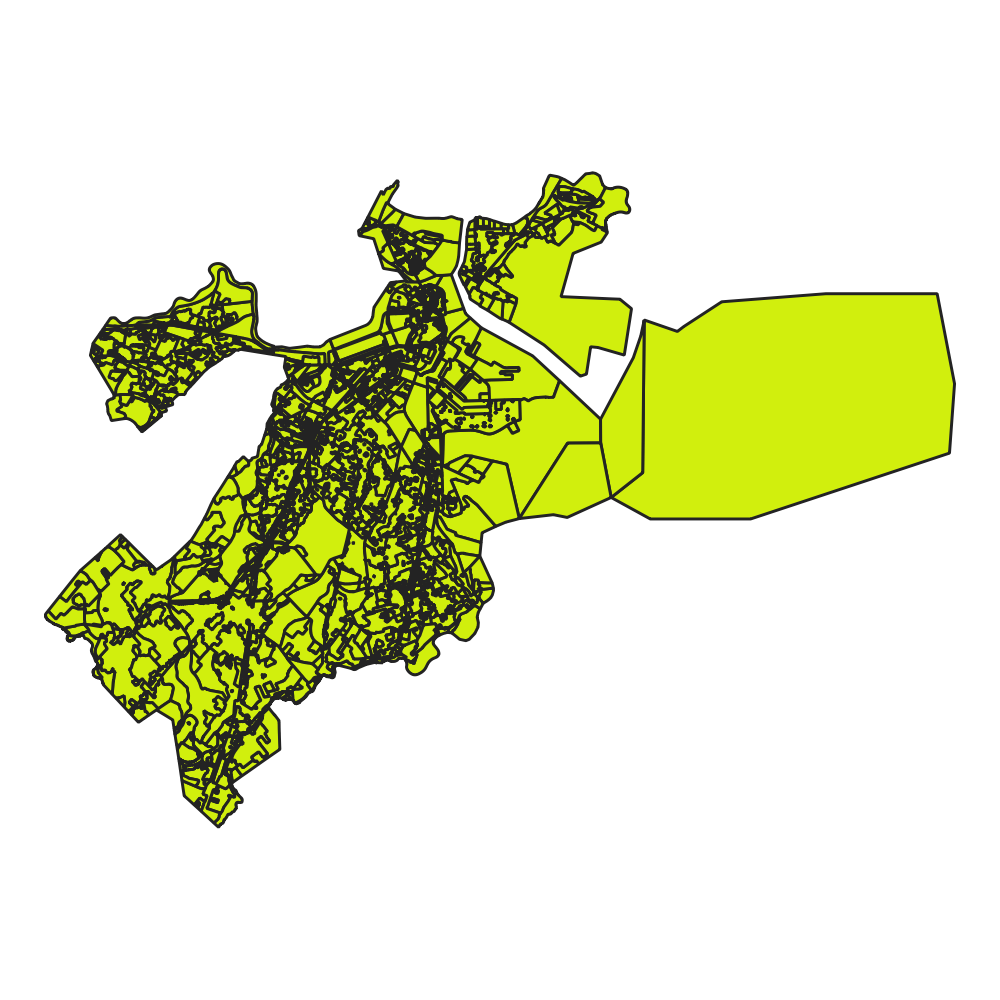

In [19]:
# Plot saved layers
display.Image(f"{IMAGES_PATH}boston_zoning_layer.png", width=500)

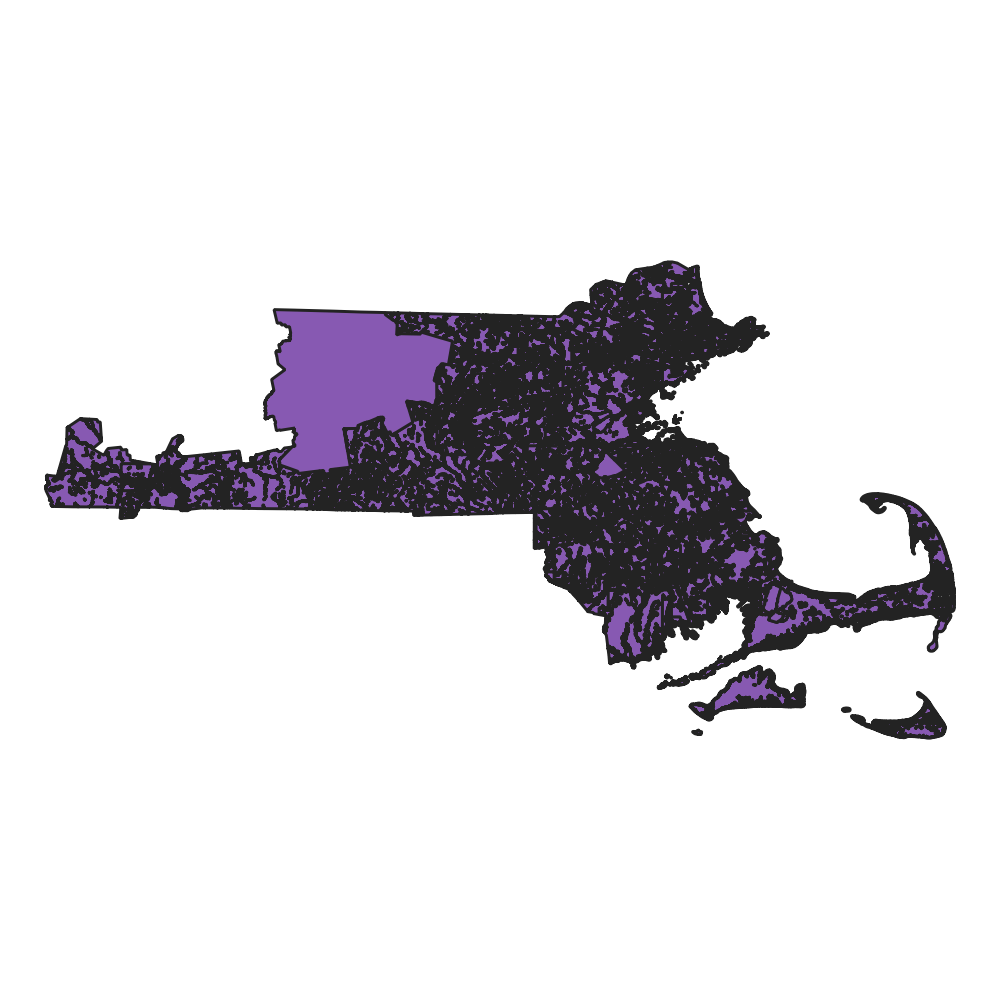

In [113]:
display.Image(f"{IMAGES_PATH}flz_haz_layer.png", width=500)

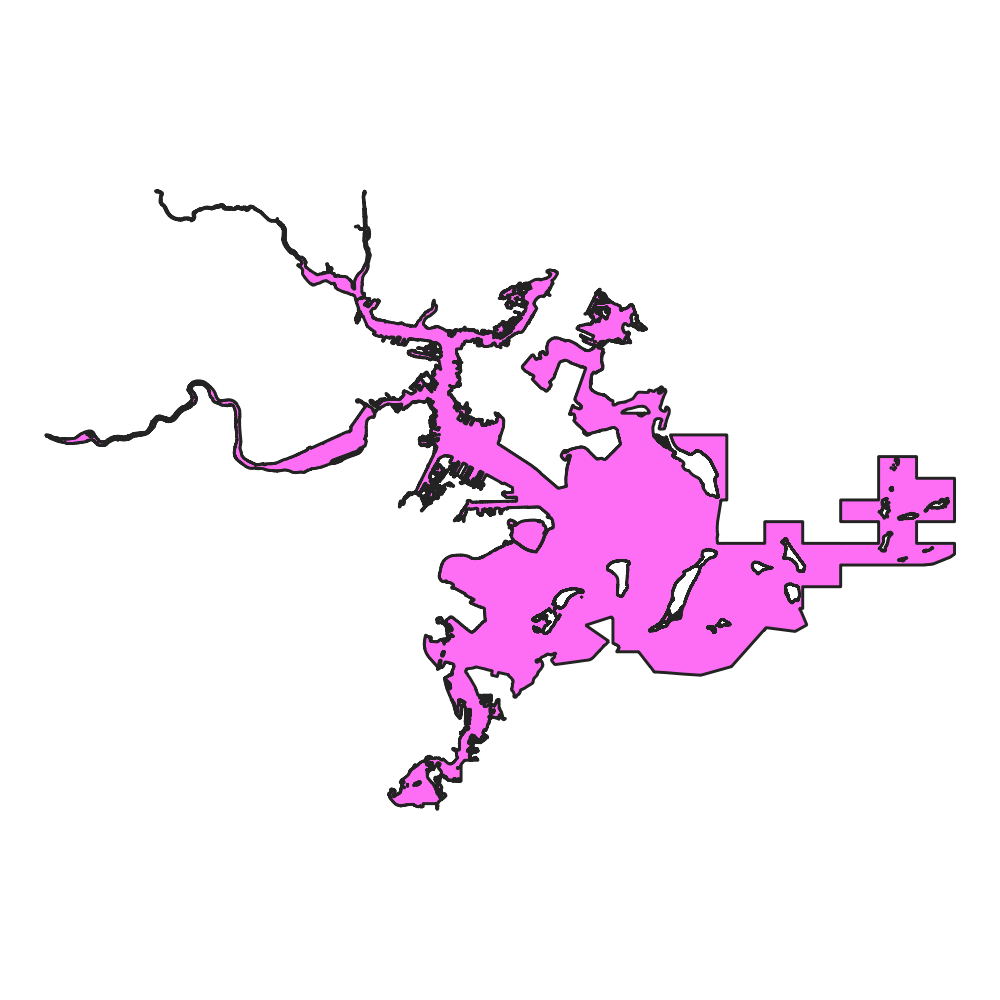

In [114]:
display.Image(f"{IMAGES_PATH}sea_level_rise_layer.png", width=500)

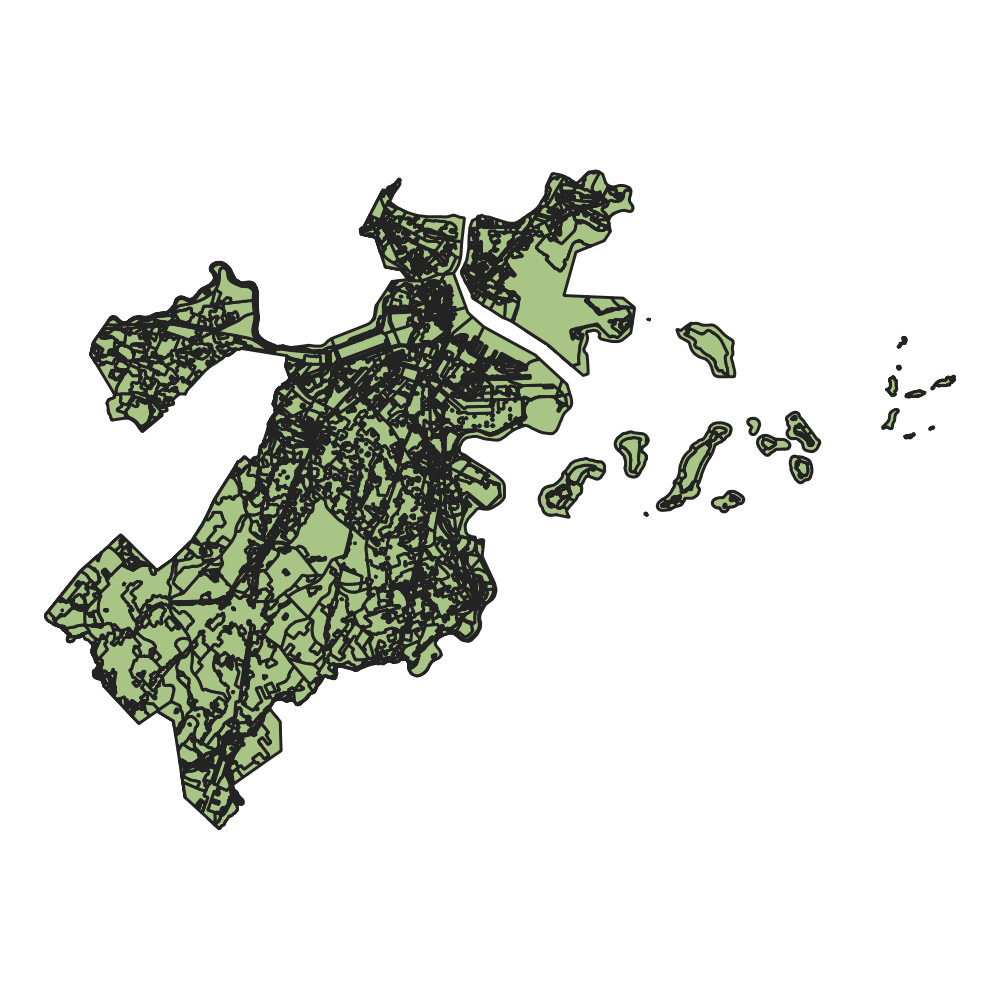

In [115]:
display.Image(f"{IMAGES_PATH}intersection_flz_boston_layer.png", width=500)

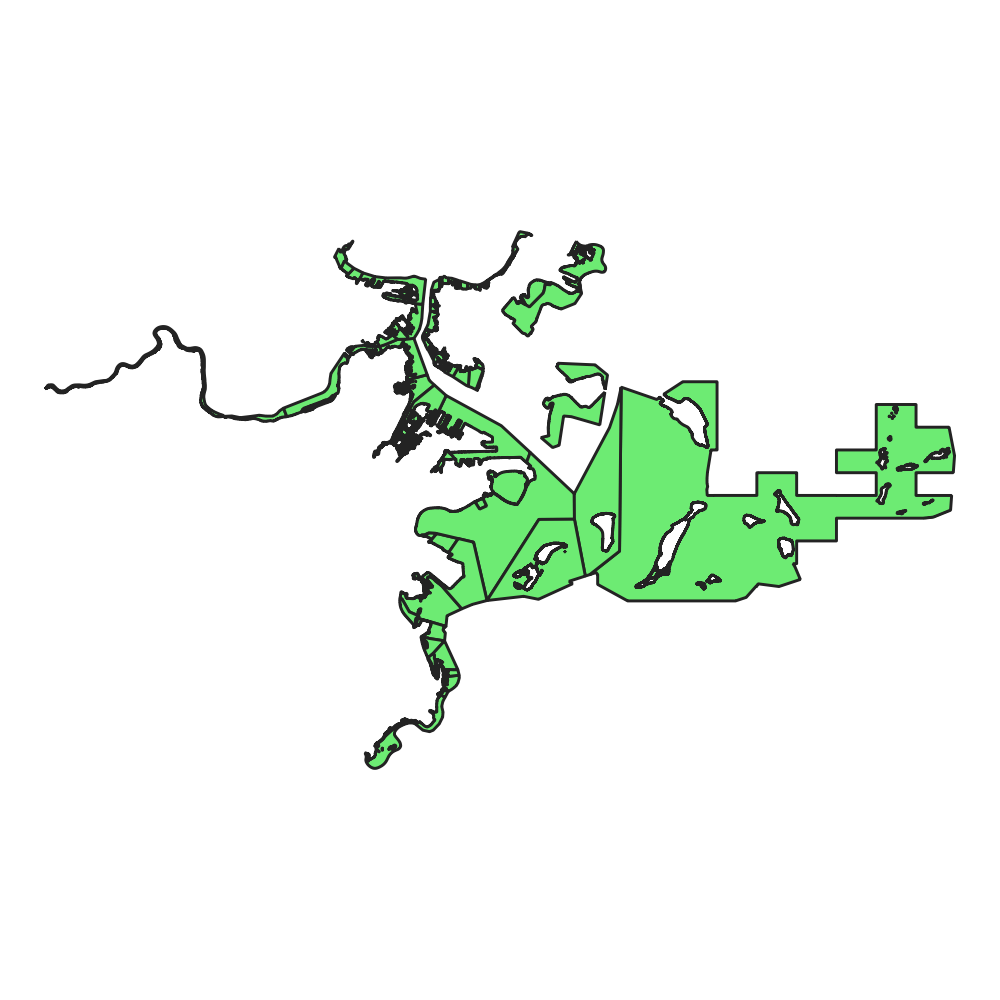

In [116]:
display.Image(f"{IMAGES_PATH}intersection_searise_boston_layer.png", width=500)

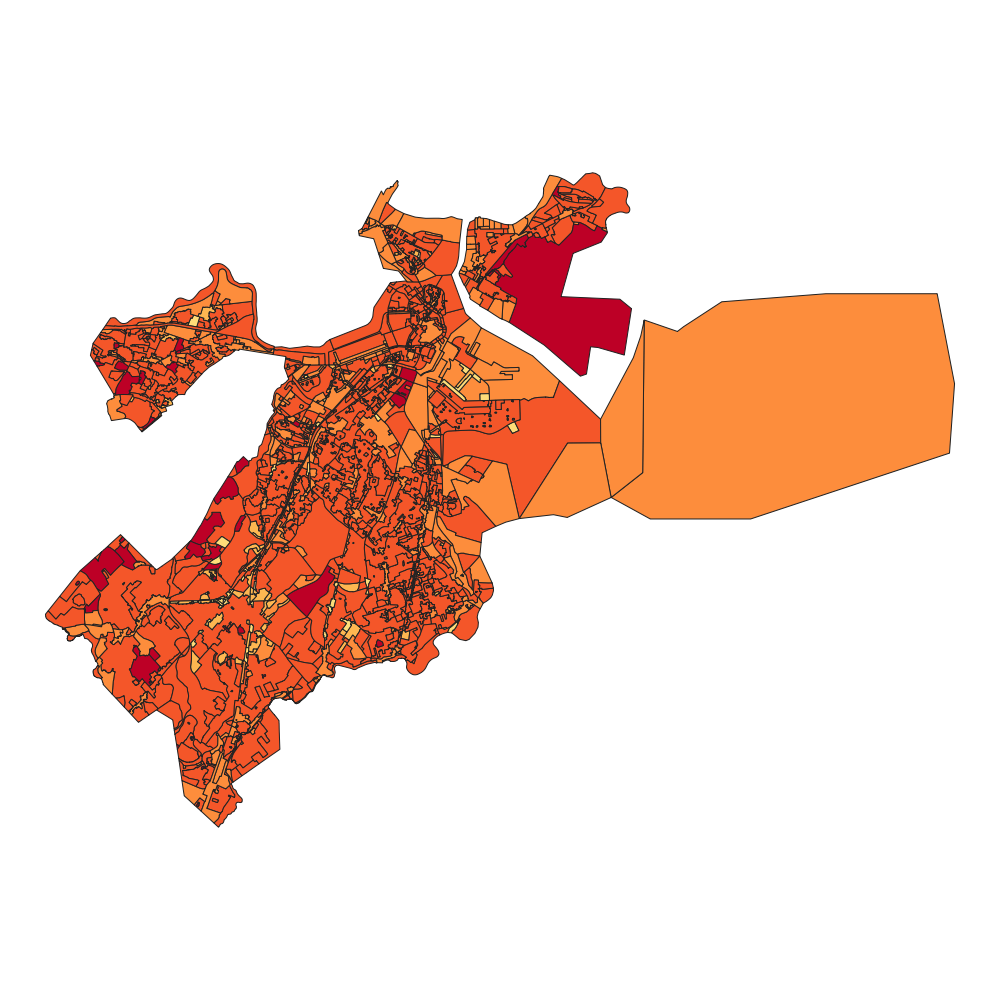

In [70]:
display.Image(f"{IMAGES_PATH}total_scores.png", width=500)